In [261]:
import pandas as pd
import math
import numpy as np
from shapely.geometry import Point, Polygon
import copy
import time
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Generate dataset <h3>

In [262]:
# open neighbourhood data file
def open_neighborhoods():
    df = pd.read_csv('SF_neighborhoods.csv')
    return df

In [263]:
# get list of neighbourhoods from neighbourhood datafile
def get_neighborhoods(df):
    neighborhoods = []
    num_neighborhoods = len(df.index)
    for x in range(0,num_neighborhoods):
        neighborhoods.append(df.iloc[x,2])
    return neighborhoods

In [264]:
# generate list of polygons representing each neighbourhood
def generate_neighborhood_polygons(df):
    neighborhoods = []
    num_neighborhoods = len(df.index)
    for x in range(0,num_neighborhoods):
        raw_polygon_data = df.iloc[x,1]
        neighborhood_polygon = generate_polygon(raw_polygon_data)
        neighborhood_name = df.iloc[x,2]
        neighborhood_tuple = (neighborhood_polygon,neighborhood_name)
        neighborhoods.append(neighborhood_tuple)
    return neighborhoods

In [265]:
# generate a polygon
def generate_polygon(raw_polygon_data):
    raw_polygon_data = raw_polygon_data[16:-3]
    coords = ''
    coords_list = []
    for char in raw_polygon_data:
        if char == ' ' or char == ',':
            if coords != '':
                coords_list.append(float(coords))
            coords = ''
        else:
            coords = coords+char
    coords_list.append(float(coords))
    x = 0
    tuple_list = []
    while x < len(coords_list):
        next_tuple = (coords_list[x+1],coords_list[x])
        tuple_list.append(next_tuple)
        x+=2
    polygon = Polygon(tuple_list)
    return polygon

In [266]:
# open sfpd data file
def open_sfpd_data():
    df = pd.read_csv('SFPD_original.csv')
    return df

In [267]:
#identify total number of records and remove uncategorised crimes
def remove_uncategorised_incidents(df):
    #identify total number of records and remove uncategorised crimes
    total_records = len(df.index)
    categorised_crimes = df['Incident Category'].count()
    uncategorised_crimes = total_records - categorised_crimes
    if uncategorised_crimes != 0:
        #drop blank incident categories and recheck values
        df = df.dropna(subset=['Incident Category'])
        df = remove_uncategorised_incidents(df)
    return df

In [268]:
# drop rows with missing values
def remove_rows_with_missing_values(df):
    num_rows = len(df.index)
    df = df.dropna()
    new_num_rows = len(df.index)
    rows_removed = num_rows - new_num_rows
    return df

In [269]:
# reset indexes of dataframe to allow for iteration
def reset_indexes(df):
    return df.reset_index(drop=True, inplace=True)

In [270]:
# drop columns deemed uneccessary
def drop_unnecessary_columns(df):
    df = df.drop(columns=['Report Datetime','Row ID', 'Incident ID',
                          'Incident Number','CAD Number','Report Type Code',
                          'Report Type Description', 'Filed Online',
                          'Incident Code','Incident Subcategory',
                          'Incident Description', 'Resolution', 'Intersection',
                          'CNN','Police District','Analysis Neighborhood',
                          'Supervisor District', 'point', 'SF Find Neighborhoods',
                          'Current Police Districts', 'Current Supervisor Districts',
                          'Analysis Neighborhoods','HSOC Zones as of 2018-06-05',
                          'OWED Public Spaces',
                          'Central Market/Tenderloin Boundary Polygon - Updated',
                          'Parks Alliance CPSI (27+TL sites)','ESNCAG - Boundary File',
                          'Areas of Vulnerability, 2016'])
    return df

In [271]:
# remove rows deemed as non-crime
def remove_rows_of_non_crime(df):
    df = df.loc[~df['Incident Category'].str.contains('Case Closure')]
    df = df.loc[~df['Incident Category'].str.contains('Courtesy Report')]
    df = df.loc[~df['Incident Category'].str.contains('Lost Property')]
    df = df.loc[~df['Incident Category'].str.contains('Missing Person')]
    df = df.loc[~df['Incident Category'].str.contains('Non-Criminal')]
    df = df.loc[~df['Incident Category'].str.contains('Suicide')]
    df = df.loc[~df['Incident Category'].str.contains('Vehicle Misplaced')]
    df = df.loc[~df['Incident Category'].str.contains('Warrant')]
    return df

In [272]:
# remove incident data prior to Uber legislation change
def remove_crime_prior_to_uber_legislation_change(df):
    df['Incident Date'] = pd.to_datetime(df['Incident Date'])
    df = df[~(df['Incident Date'] < '2018-07-01')]
    return df

In [273]:
# convert gps coordinates of each row into a neighbourhood by placing each point inside a neighbourhood polygon
def convert_gps_to_neighborhood(df,neighborhood_polygons):
    df['Neighborhood'] = np.nan
    num_records = len(df.index)
    for incident_num in range(0,num_records):
        df.iloc[incident_num,8] = ''
        shortest_distance = 999999999
        closest_neighborhood = ''
        latitude = float(df.iloc[incident_num,6])
        longitude = float(df.iloc[incident_num,7])
        point = Point(latitude,longitude)
        for poly_tuple in neighborhood_polygons:
            if poly_tuple[0].contains(point) or poly_tuple[0].touches(point):
                df.iloc[incident_num,8] = poly_tuple[1]
                break
            else:
                distance_to_neighborhood = point.distance(poly_tuple[0])
                if distance_to_neighborhood < shortest_distance:
                    shortest_distance = distance_to_neighborhood
                    closest_neighborhood = poly_tuple[1]
        if df.iloc[incident_num,8] == '':
            #place incident in closest neighborhood
            df.iloc[incident_num,8] = closest_neighborhood
            #shortest distance is over 1 mile away
            if shortest_distance > 0.018:
                print('WARNING!!! GPS coordinates for row',incident_num,'do not appear to be within 1 mile of a San Francisco Neighbourhood')
    return df

In [274]:
# drop gps coordinates after determining neighbourhood
def remove_gps_coordinates(df):
    df = df.drop(columns=['Latitude','Longitude'])
    return df

In [275]:
# group incidents per day per neighbourhood
def get_reports_per_day_per_neighborhood(df):
    df['Todays Reports'] = 1
    df = df.groupby(['Incident Date','Incident Year', 'Neighborhood',
                     'Incident Day of Week']).count()
    df = df.drop(columns=[ 'Incident Datetime','Incident Time',
                           'Incident Category'])
    df = df.reset_index()
    return df

In [276]:
# insert rows for any neighbourhood with zero crime on any given day
def check_for_missing_neighborhoods(df,neighborhoods):
    new_rows = pd.DataFrame()
    num_records = len(df.index)
    current_date = df.iloc[0,0]
    zero_crime_neighborhoods = copy.deepcopy(neighborhoods)
    for record in range(0,num_records):
        zero_crime_neighborhoods.remove(df.iloc[record,2])
        if record != num_records-1:
            if df.iloc[record+1,0] != current_date:
                for neighborhood in zero_crime_neighborhoods:
                    new_row = {'Incident Date' : current_date,
                               'Incident Year' : df.iloc[record-1,1],
                               'Neighborhood' : neighborhood,
                               'Incident Day of Week' : df.iloc[record-1,3],
                               'Todays Reports' : 0}
                    new_rows = new_rows.append(new_row,ignore_index=True)
                zero_crime_neighborhoods = copy.deepcopy(neighborhoods)
                current_date = df.iloc[record+1,0]
    for neighborhood in zero_crime_neighborhoods:
        new_row = {'Incident Date' : current_date,
                    'Incident Year' : df.iloc[len(df.index)-1,1],
                    'Neighborhood' : neighborhood,
                    'Incident Day of Week' : df.iloc[len(df.index)-1,3],
                    'Todays Reports' : 0}
        new_rows = new_rows.append(new_row,ignore_index=True)
    frames = [df,new_rows]
    new_record = pd.concat(frames)
    new_record = new_record.sort_values(['Incident Date','Neighborhood'])
    return new_record

In [277]:
# generate dataframe of last 14 days incidents
def shift_crimes(df,num_days):
    transitional_data = df.shift(periods=(117*num_days))
    transitional_data = transitional_data['Todays Reports']
    return transitional_data

In [278]:
# generate dataframe of last 28 days incidents
def get_last_14_days(df):
    transitional_data = df.shift(periods=(117*7))
    transitional_data = transitional_data['Last 7 days reports']
    return transitional_data

In [279]:
# generate dataframe of historic incidents
def get_last_28_days(df):
    transitional_data = df.shift(periods=(117*14))
    transitional_data = transitional_data['Last 14 days reports']
    return transitional_data

In [280]:
# reset dataframe indexes to allow for iteration
def generate_new_date_data(df):
    df['Reports 1 day ago'] = shift_crimes(df,1)
    df['Reports 2 days ago'] = shift_crimes(df,2)
    df['Reports 3 days ago'] = shift_crimes(df,3)
    df['Reports 4 days ago'] = shift_crimes(df,4)
    df['Reports 5 days ago'] = shift_crimes(df,5)
    df['Reports 6 days ago'] = shift_crimes(df,6)
    df['Reports 7 days ago'] = shift_crimes(df,7)
    df['Reports 14 days ago'] = shift_crimes(df,14)
    df['Reports 30 days ago'] = shift_crimes(df,30)
    df['Reports 365 days ago'] = shift_crimes(df,365)
    df['Last 7 days reports'] = (df['Reports 1 day ago'] + df['Reports 2 days ago'] + df['Reports 3 days ago']
                         + df['Reports 4 days ago'] + df['Reports 5 days ago']
                         + df['Reports 6 days ago'] + df['Reports 7 days ago'])
    df['Last 14 days reports'] = (df['Last 7 days reports'] + get_last_14_days(df))

    df['Last 28 days reports'] = (df['Last 14 days reports'] + get_last_28_days(df))
    df = df.dropna()
    return df

<h3> Generate incident data <h3>

In [281]:
df = open_neighborhoods()

In [282]:
neighborhoods = get_neighborhoods(df)

In [283]:
neighborhood_polygons = generate_neighborhood_polygons(df)

In [284]:
df = open_sfpd_data()

In [285]:
df = remove_uncategorised_incidents(df)

In [286]:
df = drop_unnecessary_columns(df)

In [287]:
df = remove_rows_with_missing_values(df)

In [288]:
df = remove_rows_of_non_crime(df)

<h3> Visualise initial incident data <h3>

In [289]:
df_by_date = df
df_by_date['Incident Date'] = pd.to_datetime(df_by_date['Incident Date'])
df_by_date['Incidents'] = 1
df_by_date = df_by_date.groupby(['Incident Date']).count()
df_by_date = df_by_date.drop(columns=['Incident Datetime', 'Incident Time','Incident Year', 'Incident Day of Week',
                                     'Incident Category', 'Latitude', 'Longitude'])

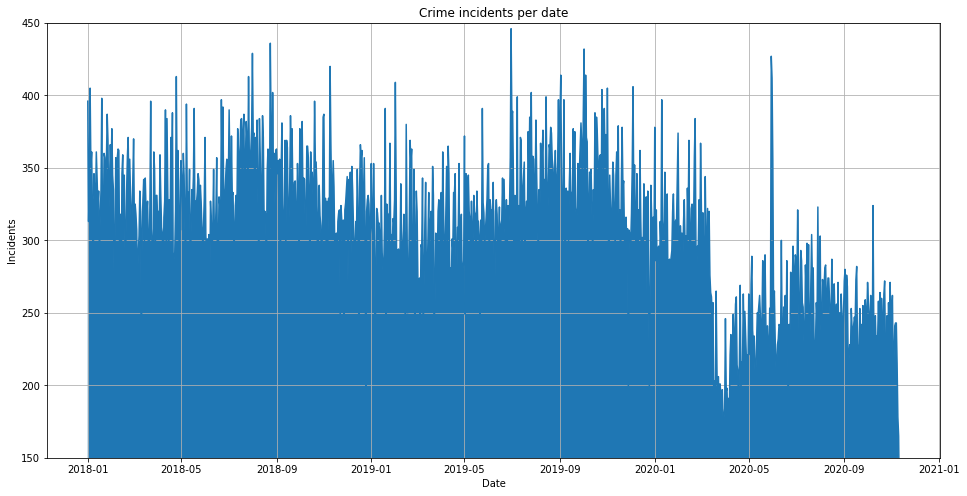

In [290]:
x = df_by_date.index.tolist()
y = df_by_date['Incidents'].tolist()
plt.figure(figsize = (16,8))
plt.grid(True)
plt.title('Crime incidents per date')
plt.xlabel('Date')
plt.ylabel('Incidents')
plt.ylim(150, 450)
plt.fill_between(x, y, interpolate=False)
plt.plot(x,y);

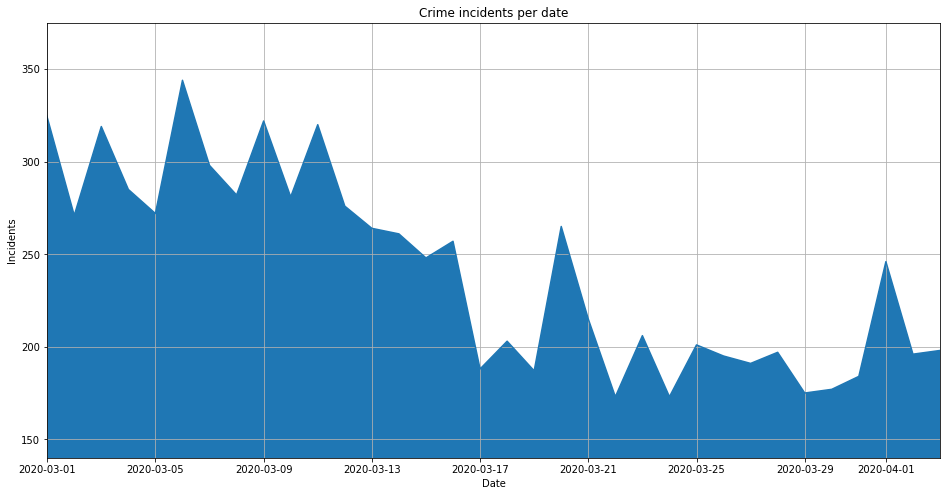

In [291]:
plt.figure(figsize = (16,8))
plt.grid(True)
plt.title('Crime incidents per date')
plt.xlabel('Date')
plt.ylabel('Incidents')
plt.ylim(140, 375)
plt.xlim([18322,18355])
plt.fill_between(x, y, interpolate=False)
plt.plot(x,y);

<h3> Convert incident data to indicents per day per neighbourhood<h3>

In [292]:
df = df.drop(columns=['Incidents'])

In [293]:
df = remove_crime_prior_to_uber_legislation_change(df)

In [295]:
df = convert_gps_to_neighborhood(df,neighborhood_polygons)

In [297]:
df = remove_gps_coordinates(df)

In [299]:
df = get_reports_per_day_per_neighborhood(df)

In [301]:
df = check_for_missing_neighborhoods(df,neighborhoods)

In [302]:
df = generate_new_date_data(df)

In [303]:
reset_indexes(df)

In [304]:
df.to_csv('SFPD_preprocessed.csv', index = False)